#K-Nearest Neighbors (k-NN)
Creating KNN classifier for CIFAR-10 from scratch with PyTorch. KNN is data driven, image classification algorithm that was popular before Deep Learning came out. So I will structure my PyTorch porfolio projects according to timeline of algorithms were developed (Popular) So I am starting with KNN


After implementing the K-Nearest Neighbor classifier, I will implement *cross-validation* to find the best value of K.

I will implement 2 versions of code 1) Vectorized (Efficient). 2) With explicit loops (Easy peasy)

## Installing module
I use some functions that developed by research group of University of Michigan to help utilize PyTorch on low-level functionality: [`coutils` package](https://github.com/deepvision-class/starter-code).


In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-ey3fgxno
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-ey3fgxno
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=fae2ca05fb72232b0709a24512c03c9596da9c73fcbed2444ec3fce99a27ec3e
  Stored in directory: /tmp/pip-ephem-wheel-cache-rdcqgyum/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


## Setup code
Importing some useful packages and increasing the default figure size.

In [ ]:
import coutils
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

## Loading the CIFAR-10 dataset
The utility function `coutils.data.cifar10()` returns the entire CIFAR-10 dataset as a set of four **Torch tensors**:

- `x_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `x_test` contains all test images
- `y_test` contains all test labels


In [ ]:
x_train, y_train, x_test, y_test = coutils.data.cifar10()

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Extracting ./cifar-10-python.tar.gz to .
Training set:
  data shape: torch.Size([50000, 3, 32, 32])
  labels shape:  torch.Size([50000])
Test set:
  data shape:  torch.Size([10000, 3, 32, 32])
  labels shape torch.Size([10000])


## Visualizing the dataset
To explore images in dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  if __name__ == '__main__':


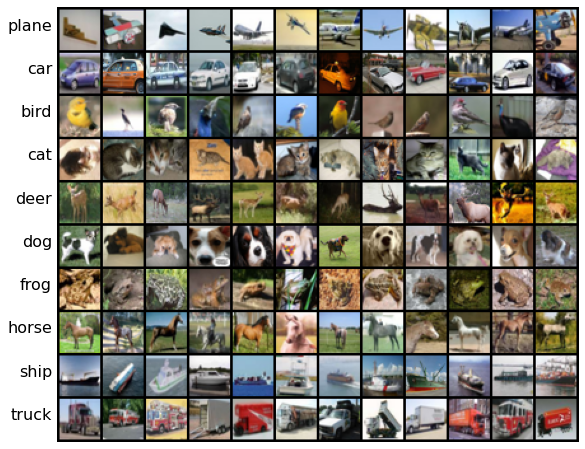

In [ ]:
import random
from torchvision.utils import make_grid

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 12
samples = []
for y, cls in enumerate(classes):
  plt.text(-4, 34 * y + 18, cls, ha='right')
  idxs = (y_train == y).nonzero().view(-1)
  for i in range(samples_per_class):
    idx = idxs[random.randrange(idxs.shape[0])].item()
    samples.append(x_train[idx])
img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.imshow(coutils.tensor_to_image(img))
plt.axis('off')
plt.show()

## Subsampling the dataset
When implementing machine learning algorithms, I usually use a small sample of the full dataset. This way my code will run much faster, allowing for more interactive and efficient development. Once I am satisfied that i have correctly implemented the algorithm, I will then rerun with the entire dataset.


I subsample the data to use only 500 training examples and 100 test examples:

In [ ]:
num_train = 500
num_test = 250

x_train, y_train, x_test, y_test = coutils.data.cifar10(num_train, num_test)

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([500, 3, 32, 32])
  labels shape:  torch.Size([500])
Test set:
  data shape:  torch.Size([250, 3, 32, 32])
  labels shape torch.Size([250])


## Computing distances: Naive implementation
Now that I have examined and prepared our data, it is time to implement the kNN classifier. I break the process down into two steps:

1. Compute the (squared Euclidean) distances between all training examples and all test examples
2. Given these distances, for each test example find its k nearest neighbors and have them vote for the label to output


In [ ]:
def compute_distances_two_loops(x_train, x_test):
  """
  Computes the squared Euclidean distance between each element of the training
  set and each element of the test set.
  This implementation uses a naive set of nested loops over the training and
  test data.
  
  Inputs:
  - x_train: Torch tensor of shape (num_train, C, H, W)
  - x_test: Torch tensor of shape (num_test, C, H, W)

  Returns:
  - dists: Torch tensor of shape (num_train, num_test) where dists[i, j] is the
    squared Euclidean distance between the ith training point and the jth test
    point.
  """
  # Initialize dists to be a tensor of shape (num_train, num_test) with the
  # same datatype and device as x_train
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]
  dists = x_train.new_zeros(num_train, num_test)
  # Implementing this function using a pair of nested loops over the        
  # training data and the test data.                                                                                                  
  # I do not use torch.norm (or its instance method variant), nor any       
  # functions from torch.nn or torch.nn.functional in order to calculate distance
  #manually.                            
  for i in range(num_train):
      for j in range(num_test):
          dists[i,j] = torch.sqrt(torch.sum((torch.flatten(x_train[i]) - torch.flatten(x_test[j]))**2))
 
  return dists
  

After implementing the function above, I run it to check that it has the expected shape:

In [ ]:
num_train = 500
num_test = 250
x_train, y_train, x_test, y_test = coutils.data.cifar10(num_train, num_test)

dists = compute_distances_two_loops(x_train, x_test)
print('dists has shape: ', dists.shape)

dists has shape:  torch.Size([500, 250])


As a visual debugging step, I can visualize the distance matrix, where each row is a test example and each column is a training example.

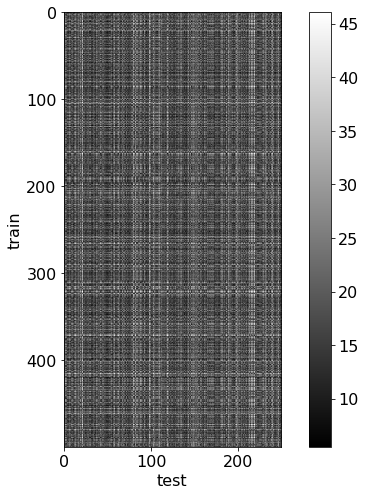

In [ ]:
plt.imshow(dists.numpy(), cmap='gray', interpolation='none')
plt.colorbar()
plt.xlabel('test')
plt.ylabel('train')
plt.show()

## Computing distances: Vectorization
My implementation of the distance computation above is fairly inefficient since it uses nested Python loops over the training and test sets.

When implementing algorithms in PyTorch, it's best to avoid loops in Python if possible. Instead it is preferable to implement my computation so that all loops happen inside PyTorch functions. This will usually be much faster than writing my own loops in Python, since PyTorch functions can be internally optimized to iterate efficiently, possibly using multiple threads. This is especially important when using a GPU to accelerate my code.

The process of eliminating explict loops from my code is called **vectorization**. I will use vectorization to improve the speed of my distance computation function.

As a first step toward vectorizing our distance computation, I complete the implementation which uses only a single Python loop over the training data:

In [ ]:
def compute_distances_one_loop(x_train, x_test):
  """
  This implementation uses only a single loop over the training data.

  Inputs:
  - x_train: Torch tensor of shape (num_train, C, H, W)
  - x_test: Torch tensor of shape (num_test, C, H, W)

  Returns:
  - dists: Torch tensor of shape (num_train, num_test) where dists[i, j] is the
    squared Euclidean distance between the ith training point and the jth test
    point.
  """
  # Initialize dists to be a tensor of shape (num_train, num_test) with the
  # same datatype and device as x_train
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]
  dists = x_train.new_zeros(num_train, num_test)
  # Implement this function using only a single loop over x_train.                                                                       
  # I do not use torch.norm (or its instance method variant), nor any       
  # functions from torch.nn or torch.nn.functional in order to calculate distance
  #manually.                                                      
  for i,j in enumerate(x_train):
      dists[i,:] = (torch.flatten(j)-torch.flatten(x_test,start_dim=1)).pow(2).sum(dim=1).sqrt()

  return dists

I can check the correctness of my one-loop implementation by comparing it with my two-loop implementation on some randomly generated data.


In [ ]:
dists = compute_distances_one_loop(x_train, x_test)
print('dists has shape: ', dists.shape)
torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_one = compute_distances_one_loop(x_train_rand, x_test_rand)
dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
difference = (dists_one - dists_two).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
  print('Good! The distance matrices match')
else:
  print('Uh-oh! The distance matrices are different')
print(dists_one.size())
print(dists_two.size())

dists has shape:  torch.Size([500, 250])
Difference:  0.0
Good! The distance matrices match
torch.Size([100, 100])
torch.Size([100, 100])


Now I implement a fully vectorized version of the distance computation function
that does not use any python loops.

In [ ]:
def compute_distances_no_loops(x_train, x_test):
  """
  This implementation does not use any Python loops.
  Inputs:
  - x_train: Torch tensor of shape (num_train, C, H, W)
  - x_test: Torch tensor of shape (num_test, C, H, W)

  Returns:
  - dists: Torch tensor of shape (num_train, num_test) where dists[i, j] is the
    squared Euclidean distance between the ith training point and the jth test
    point.
  """
  # Initialize dists to be a tensor of shape (num_train, num_test) with the
  # same datatype and device as x_train
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]
  dists = x_train.new_zeros(num_train, num_test)
  # Implementing this function without using any explicit loops                                                                                                                                                                               
  train = torch.sum(torch.flatten(x_train,start_dim=1).pow(2),dim=1).view(-1,1)
  test = torch.sum(torch.flatten(x_test,start_dim=1).pow(2),dim=1).view(1,-1)
  xy = torch.mm(torch.flatten(x_train,start_dim=1),torch.transpose(torch.flatten(x_test,start_dim=1),0,1))
  dists = torch.sqrt(train+test-2*xy)

  return dists

As before, I can check the correctness of my implementation by comparing the fully vectorized version against the original naive version:

In [ ]:
torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
dists_none = compute_distances_no_loops(x_train_rand, x_test_rand)
difference = (dists_two - dists_none).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
  print('Good! The distance matrices match')
else:
  print('Uh-oh! The distance matrices are different')

Difference:  3.6188883934320425e-13
Good! The distance matrices match


Now I compare the speed of my three implementations.

In [ ]:
import time

def timeit(f, *args):
  tic = time.time()
  f(*args) 
  toc = time.time()
  return toc - tic

torch.manual_seed(0)
x_train_rand = torch.randn(500, 3, 32, 32)
x_test_rand = torch.randn(500, 3, 32, 32)

two_loop_time = timeit(compute_distances_two_loops, x_train_rand, x_test_rand)
print('Two loop version took %.2f seconds' % two_loop_time)

one_loop_time = timeit(compute_distances_one_loop, x_train_rand, x_test_rand)
speedup = two_loop_time / one_loop_time
print('One loop version took %.2f seconds (%.1fX speedup)'
      % (one_loop_time, speedup))

no_loop_time = timeit(compute_distances_no_loops, x_train_rand, x_test_rand)
speedup = two_loop_time / no_loop_time
print('No loop version took %.2f seconds (%.1fX speedup)'
      % (no_loop_time, speedup))

Two loop version took 8.95 seconds
One loop version took 1.18 seconds (7.6X speedup)
No loop version took 0.04 seconds (202.8X speedup)


## Predict labels
Now that I have a method for computing distances between training and test examples, I need to implement a function that uses those distances together with the training labels to predict labels for test samples.


In [ ]:
def predict_labels(dists, y_train, k=1):
  """
  Given distances between all pairs of training and test samples, predict a
  label for each test sample by taking a majority vote among its k nearest
  neighbors in the training set.
  In the event of a tie, this function returns the smaller label. For
  example, if k=5 and the 5 nearest neighbors to a test example have labels
  [1, 2, 1, 2, 3] then there is a tie between 1 and 2 (each have 2 votes), so
  we should return 1 since it is the smaller label.

  Inputs:
  - dists: Torch tensor of shape (num_train, num_test) where dists[i, j] is the
    squared Euclidean distance between the ith training point and the jth test
    point.
  - y_train: Torch tensor of shape (y_train,) giving labels for all training
    samples. Each label is an integer in the range [0, num_classes - 1]
  - k: The number of nearest neighbors to use for classification.

  Returns:
  - y_pred: A torch int64 tensor of shape (num_test,) giving predicted labels
    for the test data, where y_pred[j] is the predicted label for the jth test
    example. Each label should be an integer in the range [0, num_classes - 1].
  """
  num_train, num_test = dists.shape
  y_pred = torch.zeros(num_test, dtype=torch.int64)

  for i in range(num_test):
      vals,inds = torch.topk(dists[:,i],k=k, largest=False,sorted=True)
      alist = [y_train[inds[j]].item() for j in range(k)]
      best = max(set(alist), key = alist.count)
      y_pred[i] = best

  return y_pred

Now I have implemented all the required functionality for the K-Nearest Neighbor classifier. I define a simple object to encapsulate the classifier:

In [ ]:
class KnnClassifier:
  def __init__(self, x_train, y_train):
    """
    Creates a new K-Nearest Neighbor classifier with the specified training data.
    In the initializer we simply memorize the provided training data.

    Inputs:
    - x_train: Torch tensor of shape (num_train, C, H, W) giving training data
    - y_train: int64 torch tensor of shape (num_train,) giving training labels
    """
    self.x_train = x_train.contiguous()
    self.y_train = y_train.contiguous()
  
  def predict(self, x_test, k=1):
    """
    Makes predictions using the classifier.
    Inputs:
    - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
    - k: The number of neighbors to use for predictions 
    Returns:
    - y_test_pred: Torch tensor of shape (num_test,) giving predicted labels
      for the test samples.
    """
    dists = compute_distances_no_loops(self.x_train, x_test.contiguous())
    y_test_pred = predict_labels(dists, self.y_train, k=k)
    return y_test_pred
  
  def check_accuracy(self, x_test, y_test, k=1, quiet=False):
    """
    Utility method for checking the accuracy of this classifier on test data.
    Returns the accuracy of the classifier on the test data, and also prints a
    message giving the accuracy.

    Inputs:
    - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
    - y_test: int64 torch tensor of shape (num_test,) giving test labels
    - k: The number of neighbors to use for prediction
    - quiet: If True, don't print a message.
  
    Returns:
    - accuracy: Accuracy of this classifier on the test data, as a percent.
      Python float in the range [0, 100]
    """
    y_test_pred = self.predict(x_test, k=k)
    num_samples = x_test.shape[0]
    num_correct = (y_test == y_test_pred).sum().item()
    accuracy = 100.0 * num_correct / num_samples
    msg = (f'Got {num_correct} / {num_samples} correct; '
           f'accuracy is {accuracy:.2f}%')
    if not quiet:
      print(msg)
    return accuracy

Now I put everything together and test my K-NN clasifier on a subset of CIFAR-10, using k=1:

In [ ]:
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = coutils.data.cifar10(num_train, num_test)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=1)

Got 137 / 500 correct; accuracy is 27.40%


27.4

Now I try to increase to k=5.

In [ ]:
classifier.check_accuracy(x_test, y_test, k=5)

Got 139 / 500 correct; accuracy is 27.80%


27.8

## Cross-validation
I have implemented the full k-Nearest Neighbor classifier, but the choice of $k=5$ was arbitrary. I will use **cross-validation** to set this hyperparameter in a more principled manner.


In [ ]:
def knn_cross_validate(x_train, y_train, num_folds=5, k_choices=None):
  """
  Perform cross-validation for KnnClassifier.

  Inputs:
  - x_train: Tensor of shape (num_train, C, H, W) giving all training data
  - y_train: int64 tensor of shape (num_train,) giving labels for training data
  - num_folds: Integer giving the number of folds to use
  - k_choices: List of integers giving the values of k to try
 
  Returns:
  - k_to_accuracies: Dictionary mapping values of k to lists, where
    k_to_accuracies[k][i] is the accuracy on the ith fold of a KnnClassifier
    that uses k nearest neighbors.
  """
  if k_choices is None:
    # Use default values
    k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

  # First we divide the training data into num_folds equally-sized folds.
  x_train_folds = []
  y_train_folds = []     
  x_train_folds = torch.chunk(x_train,num_folds)
  y_train_folds = torch.chunk(y_train,num_folds)

  k_to_accuracies = {}

  for k in k_choices:
      alist = []
      for i in range(num_folds):
          x = torch.cat(x_train_folds[:i]+x_train_folds[i+1:])
          y = torch.cat(y_train_folds[:i]+y_train_folds[i+1:])
          classifier = KnnClassifier(x, y)
          acc = classifier.check_accuracy(x_train_folds[i], y_train_folds[i], k=k,quiet=True)
          alist.append(acc)
      k_to_accuracies[k] = alist

  return k_to_accuracies

Now I use cross-validation function:




In [ ]:
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = coutils.data.cifar10(num_train, num_test)

k_to_accuracies = knn_cross_validate(x_train, y_train, num_folds=5)

for k, accs in sorted(k_to_accuracies.items()):
  print('k = %d got accuracies: %r' % (k, accs))

k = 1 got accuracies: [26.3, 25.7, 26.4, 27.8, 26.6]
k = 3 got accuracies: [24.1, 24.9, 24.3, 27.3, 26.4]
k = 5 got accuracies: [25.6, 27.1, 28.0, 28.9, 27.8]
k = 8 got accuracies: [26.3, 28.7, 27.6, 28.8, 27.0]
k = 10 got accuracies: [26.6, 29.6, 27.9, 28.3, 28.3]
k = 12 got accuracies: [26.1, 29.4, 28.0, 28.3, 28.0]
k = 15 got accuracies: [25.3, 29.0, 27.9, 28.0, 27.5]
k = 20 got accuracies: [27.0, 27.9, 27.9, 28.0, 28.4]
k = 50 got accuracies: [27.1, 28.8, 27.8, 26.9, 26.6]
k = 100 got accuracies: [25.6, 27.0, 26.3, 25.6, 26.3]


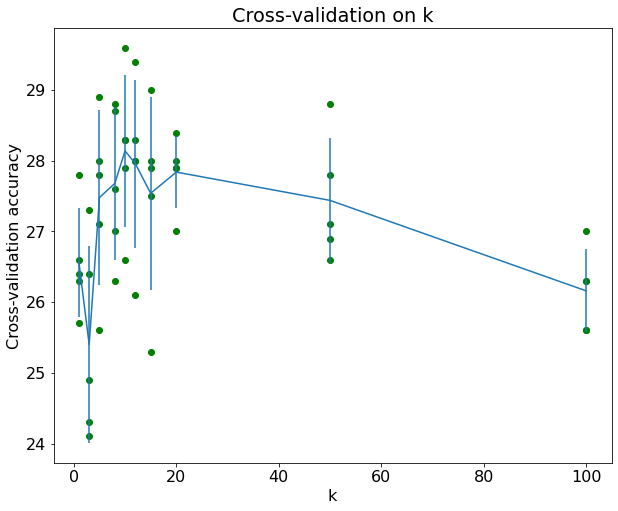

In [ ]:
ks, means, stds = [], [], []
for k, accs in sorted(k_to_accuracies.items()):
  plt.scatter([k] * len(accs), accs, color='g')
  ks.append(k)
  means.append(statistics.mean(accs))
  stds.append(statistics.stdev(accs))
plt.errorbar(ks, means, yerr=stds)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.title('Cross-validation on k')
plt.show()

Now I use the results of cross-validation to select the best value for k, and rerun the classifier on full 5000 set of training examples.

In [ ]:
best_k = 1
# Usings the results of cross-validation stored in k_to_accuracies to     
# choose the value of k, and store the result in best_k. We should choose   
# the value of k that has the highest mean accuracy accross all folds.    
means = []
ks = []
k_to_accuracies = knn_cross_validate(x_train, y_train, num_folds=5)
for k, accs in sorted(k_to_accuracies.items()):
    means.append(statistics.mean(accs))
    ks.append(k)
k = means.index(max(means))
best_k = ks[k]
    
print('Best k is ', best_k)
classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=best_k)

Best k is  10
Got 141 / 500 correct; accuracy is 28.20%


28.2

Finally, I can use my chosen value of k to run on the entire training and test sets.


In [ ]:
x_train_all, y_train_all, x_test_all, y_test_all = coutils.data.cifar10()
classifier = KnnClassifier(x_train_all, y_train_all)
classifier.check_accuracy(x_test_all, y_test_all, k=best_k)

Got 3385 / 10000 correct; accuracy is 33.85%


33.85